# Modelling the behavior of a damped single pendulum

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, Bidirectional

import random
from random import seed, random
from sklearn.utils import shuffle
from sklearn import preprocessing

%matplotlib inline

/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/bipe26194/miniconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
np.random.seed(1337)  # for reproducibility

raw_data = pd.read_csv("data/MAP_WhitePen1.csv", na_filter=False)

# The first 5 rows of the csv
print(raw_data.head(5))

   VideoAnalysis: Time (s)  VideoAnalysis: X  VideoAnalysis: Y  \
0                 0.000000          5.816870          2.713342   
1                17.984633          0.259602        536.029317   
2                27.827800        409.940908        156.002507   
3                27.861167        408.413849        152.111882   
4                27.894533        395.640027        142.170234   

   VideoAnalysis: X Velocity  VideoAnalysis: Y Velocity  
0                   7.094623                  17.556862  
1                  14.407010                   5.374901  
2                  27.572473                 -17.006521  
3                 -92.153838                -116.531409  
4                -287.258757                -258.118791  


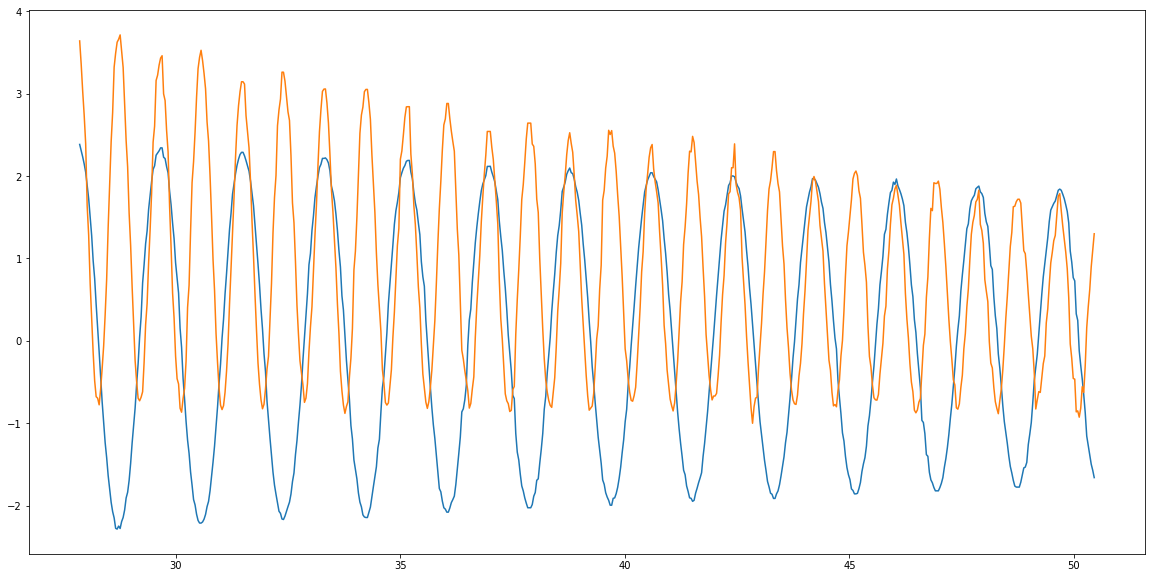

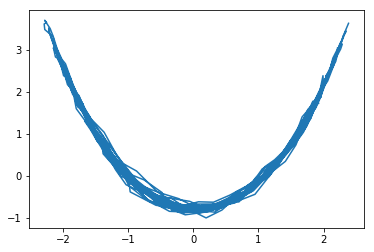

In [3]:
window = 1
edge = int(np.ceil(window/2))

def preprocess(data):
    # Calculate the moving average
    data = data.rolling(window=window,center=True).mean()
    # Trim the data that wasn't part of the moving average
    data = data[edge:-edge]
    # Standardize the data
    return preprocessing.scale(data) 

time_data = raw_data["VideoAnalysis: Time (s)"][edge:-edge].values
X_data = preprocess(raw_data["VideoAnalysis: X"])
Y_data = preprocess(raw_data["VideoAnalysis: Y"])

a = 2
b = 680
data1 = X_data[a:b]
data2 = Y_data[a:b]
time = time_data[a:b]
plt.figure(figsize=(20,10))
# plt.plot(x)
plt.plot(time, data1)
plt.plot(time, data2)
plt.figure()
plt.plot(data1, data2)

xy_pair = [[x, y] for x, y in zip(X_data, Y_data)]
data = np.array(xy_pair[a:b])

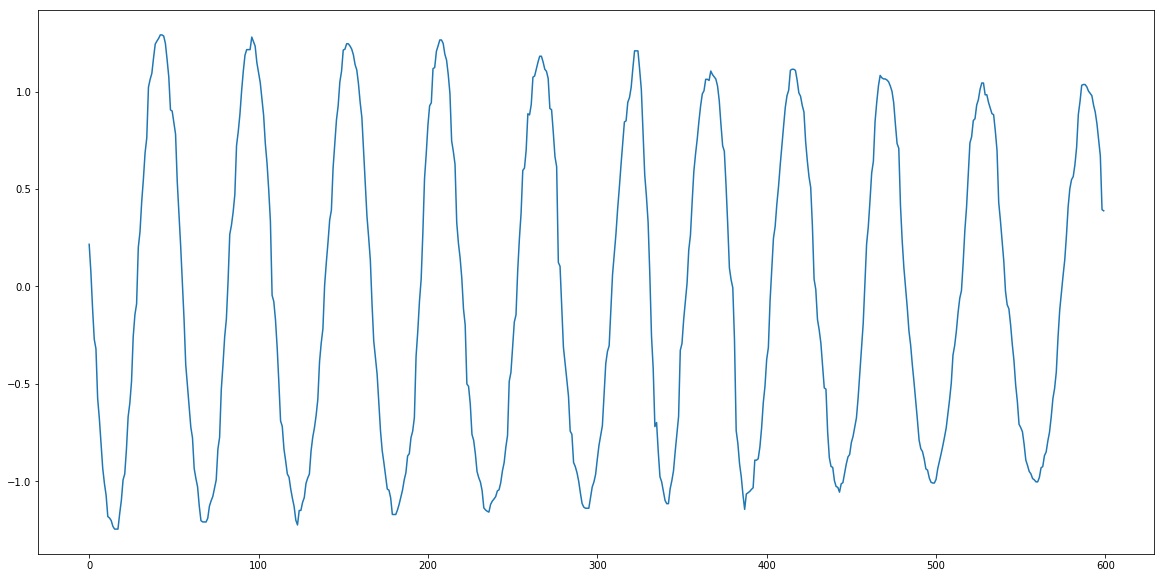

In [4]:
c = 700
d = 1300
data1 = X_data[c:d]
time1 = time_data[c:d]
plt.figure(figsize=(20,10))
# plt.plot(x)
plt.plot(data1)

In [5]:
# hyperparameters
DATA_DIM = 2
N_PREV = 55 # number of previous steps used to predict the next step

In [6]:
def _load_data(data, n_prev=N_PREV, is_shuffled=False):
    docX, docY = [], []
    for j in range(len(data)-n_prev):
        docX.append(data[j:j+n_prev])
        docY.append(data[j+n_prev])   
    alsX = np.array(docX)
    alsY = np.array(docY)
    if is_shuffled: 
        alsX, alsY = shuffle(alsX, alsY)

    return alsX.reshape(alsX.shape[0], alsX.shape[1], DATA_DIM), alsY.reshape(alsY.shape[0], DATA_DIM)

def train_test_split(data, test_size=0.6):  
    """
    This just splits data to training and testing parts
    """
    ntrn = int(round(len(data) * (1 - test_size)))

    X_train, y_train = _load_data(data[0:ntrn], is_shuffled=True)
    X_test, y_test = _load_data(data[ntrn:])

    return (X_train, y_train), (X_test, y_test)


# retrieve data
(X_train, y_train), (X_test, y_test) = train_test_split(data, 0.1)

# extra data
# (X_train1, y_train1), (X_test1, y_test1) = train_test_split(data1, 0.1)
# X_train = np.append(X_train, X_train1, axis=0)
# y_train = np.append(y_train, y_train1, axis=0)
# X_train, y_train = shuffle(X_train, y_train)

In [71]:
# define model structure
model = Sequential()
model.add(Bidirectional(CuDNNLSTM(units=5, return_sequences=True), input_shape=(None, DATA_DIM)))
model.add(Bidirectional(CuDNNLSTM(units=2, return_sequences=False)))
# model.add(Bidirectional(CuDNNLSTM(units=50, return_sequences=False)))
# model.add(Bidirectional(CuDNNLSTM(units=10, return_sequences=False)))
model.add(Dense(units=2, activation="linear"))
model.compile(loss="mean_squared_error", optimizer="adam")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_13 (Bidirectio (None, None, 10)          360       
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 4)                 224       
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 10        
Total params: 594
Trainable params: 594
Non-trainable params: 0
_________________________________________________________________


In [78]:
# and now train the model
# batch_size should be appropriate to your memory size
# number of epochs should be higher for real world problems
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.05)

Train on 527 samples, validate on 28 samples
Epoch 1/100
527/527 [==============================] - 1s 1ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 2/100
527/527 [==============================] - 1s 1ms/step - loss: 0.0075 - val_loss: 0.0064
Epoch 3/100
527/527 [==============================] - 1s 1ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 4/100
527/527 [==============================] - 1s 1ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 5/100
527/527 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 0.0073
Epoch 6/100
527/527 [==============================] - 1s 1ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 7/100
527/527 [==============================] - 1s 1ms/step - loss: 0.0066 - val_loss: 0.0067
Epoch 8/100
527/527 [==============================] - 1s 1ms/step - loss: 0.0067 - val_loss: 0.0071
Epoch 9/100
527/527 [==============================] - 1s 2ms/step - loss: 0.0066 - val_loss: 0.0076
Epoch 10/100
527/527 [========================

Epoch 81/100
527/527 [==============================] - 1s 2ms/step - loss: 0.0059 - val_loss: 0.0061
Epoch 82/100
527/527 [==============================] - 1s 1ms/step - loss: 0.0061 - val_loss: 0.0067
Epoch 83/100
527/527 [==============================] - 1s 1ms/step - loss: 0.0061 - val_loss: 0.0064
Epoch 84/100
527/527 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0059
Epoch 85/100
527/527 [==============================] - 1s 1ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 86/100
527/527 [==============================] - 1s 1ms/step - loss: 0.0056 - val_loss: 0.0063
Epoch 87/100
527/527 [==============================] - 1s 1ms/step - loss: 0.0060 - val_loss: 0.0066
Epoch 88/100
527/527 [==============================] - 1s 1ms/step - loss: 0.0059 - val_loss: 0.0061
Epoch 89/100
527/527 [==============================] - 1s 1ms/step - loss: 0.0059 - val_loss: 0.0063
Epoch 90/100
527/527 [==============================] - 1s 1ms/step - loss: 0.0063

dict_keys(['val_loss', 'loss'])
100


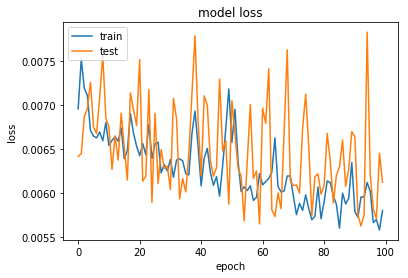

In [79]:
print(history.history.keys())
print(len(history.history['val_loss']))
# summarize history for loss
plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [80]:
# evaluate model fit
test_prediction = model.predict(X_test)
# score = model.evaluate(X_test, y_test)
# evaluate
print('Test score:', np.mean((test_prediction-y_test)**2))

Test score: 0.00688967849580135


In [81]:
# generate the time axis for visualization
t_step = np.mean(time[1:]-time[:-1])
t_start = time[-len(y_test)]

def gen_time(data):
    t = np.arange(t_start, t_start+len(data)*t_step, t_step)
    return t

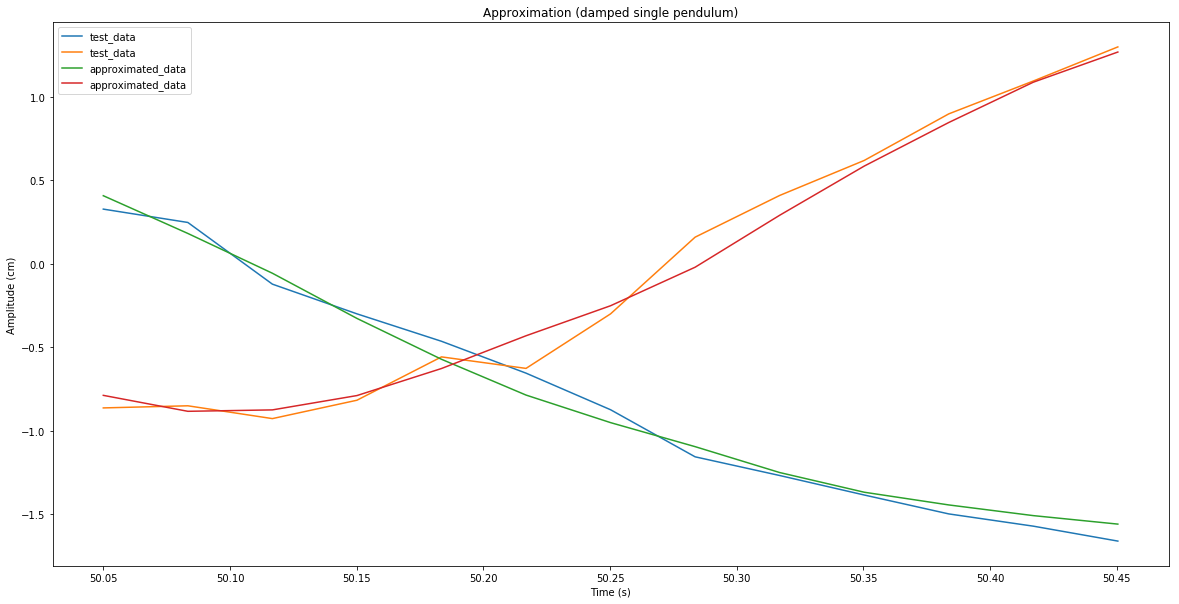

In [82]:
# visualize approximation performance on test data set
t1 = gen_time(y_test)

plt.figure(figsize=(20,10))
plt.plot(t1[:len(y_test)], y_test[:], label='test_data')
plt.plot(t1[:len(y_test)], test_prediction[:], label='approximated_data')
plt.title('Approximation (damped single pendulum)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (cm)')
plt.legend()

In [83]:
# perform modelling
X_model = data[0:N_PREV]
modelled_data = list(data[0:N_PREV])
dims = 1, X_model.shape[0], DATA_DIM
for i in range(len(data)*3):
    prev_steps = X_model.reshape(*dims)
    next_step = model.predict(prev_steps)
    modelled_data.append(next_step[0])
    X_model = np.append(X_model[1:], next_step, axis=0)
    
# evaluate
modelled_data = np.append(data[0:N_PREV], np.array(modelled_data), axis=0)
print('Prediction score:', np.mean((modelled_data[:len(data)]-data)**2))

Prediction score: 0.01389771010654629


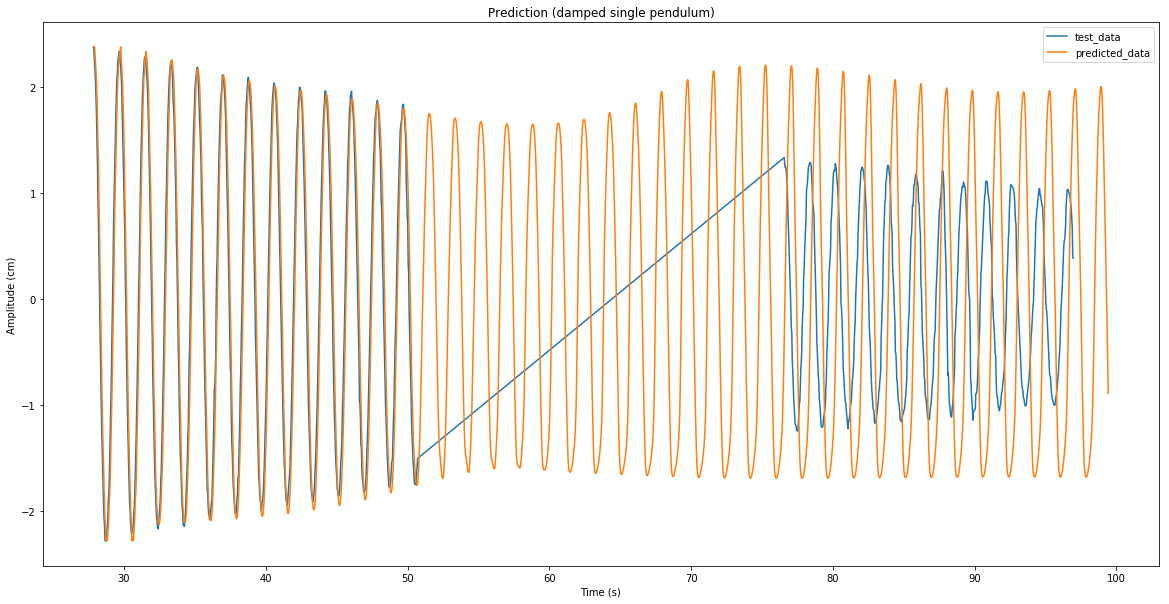

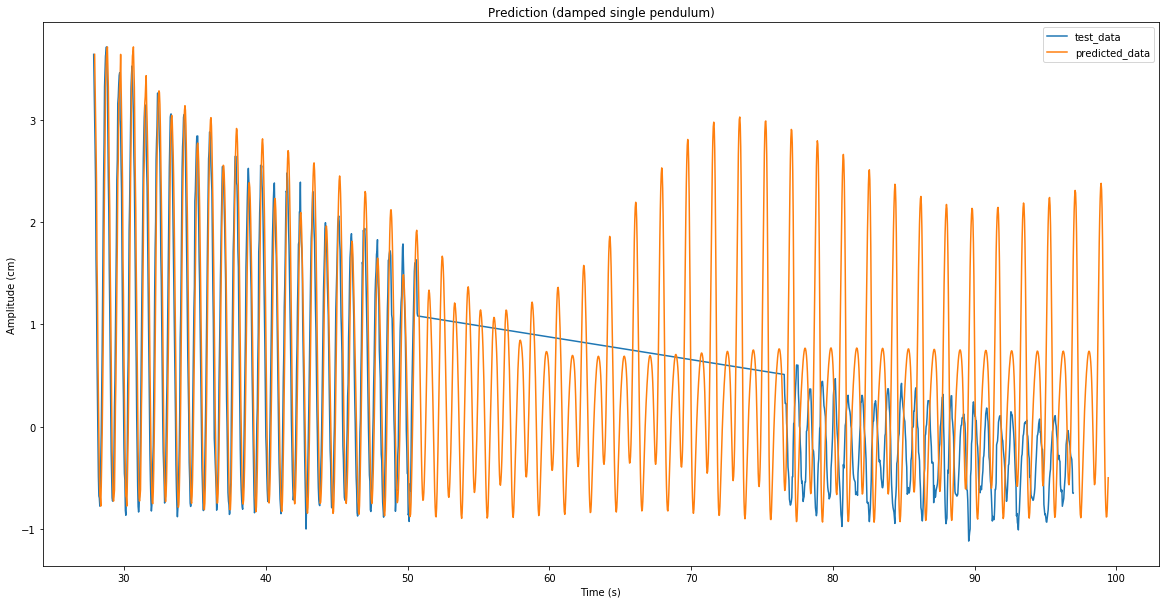

In [84]:
# visualize prediction performance
t_start = time[a]
t2 = np.arange(t_start, t_start+len(modelled_data)*t_step, t_step)

plt.figure(figsize=(20,10))
plt.plot(time_data[a:d], X_data[a:d], label='test_data')
plt.plot(t2[:len(modelled_data)], modelled_data[:,0], label='predicted_data')
plt.title('Prediction (damped single pendulum)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (cm)')
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(time_data[a:d], Y_data[a:d], label='test_data')
plt.plot(t2[:len(modelled_data)], modelled_data[:,1], label='predicted_data')
plt.title('Prediction (damped single pendulum)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (cm)')
plt.legend()

In [67]:
# visualize approximations
train_prediction = model.predict(X_train)

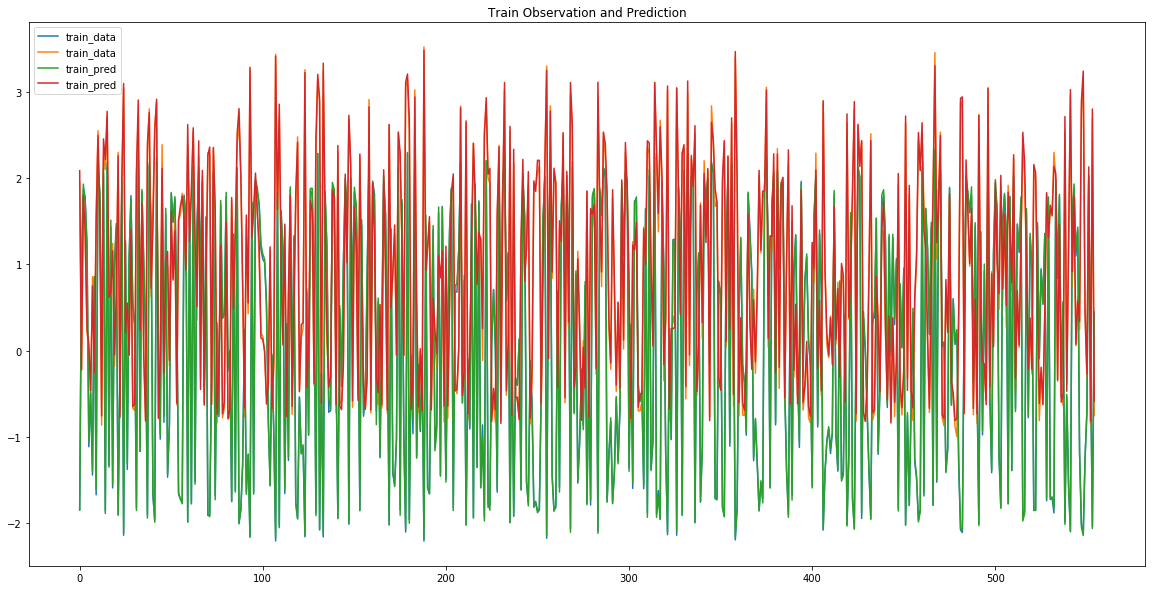

In [26]:
plt.figure(figsize=(20,10))
plt.plot(y_train[:], label='train_data')
plt.plot(train_prediction[:], label='train_pred')
plt.title('Train Observation and Prediction')
plt.legend()